In [17]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import norm

# Set plot style
sns.set_style('darkgrid')
from src.stock_path_simulator import StockPathSimulator

# American Options

American options are options where the owner can choose to exercise them at _any_ point up to and including the expiration date. Because this provides an additional mechanism to exercise compared to European options (which only allow exercise at the expiration date), American options are at least as valuable as their European counterparts, and their difference depends on the value of early exercise, called the _early exercise premium_. 

The premium depends on various factors. In the Black-Scholes model, American and European call options for non-dividend-paying stocks are generally priced the same (for dividend-paying stocks, deep-in-the-money option holders may wish to exercise before a dividend date to obtain dividends). However, put options can have substantial differences when it makes sense for the option holder to exercise early and invest the income at prevailing interest rates.

## Perpetual American Put Options

The simplest theoretical case of an American Put Option is a perpetual one where the expiration date is set to infinity. One can assume that, because time is set to infinite, the strategy of whether to exercise or not depends only on the price of the stock, not on time. The price of the perpetual American put is defined as:

$$
v(x) = \max_{\tau\in T} \tilde{E}[e^{-r\tau}(K-S(\tau))]
$$

where $K$ is the strike price, $S(\tau)$ is the price of the underlying asset at time $\tau$, $T$ is the set of all stopping times, and the exponential term tracks the growth of money under fixed interest rate $r$. 

Assume that the stock asset is priced as a geometric Brownian motion:

$$
S(t) = S(0) \exp\left\{\sigma \tilde{W}(t) + \left(r-\frac{1}{2}\sigma^2\right) t\right\}
$$

with a Wiener process $\tilde{W}(t)$. If the owner uses a strategy to exercise the option as soon as it falls below a value $L$, exercising at $\tau_L = \min(t\geq 0;S(t)=L)$, then the value function is:

$$
v_L(x)=\begin{cases}
K - x, & 0 \le x \le L,\\[6pt]
(K-L)\left(\dfrac{x}{L}\right)^{-\frac{2r}{\sigma^{2}}}, & x \ge L .
\end{cases}
$$

where the first case corresponds to exercising at $t=0$ (the stock value is below $L$), and the second case is the expected value when waiting for the stock price to drop below $L$. Following Steve Shreve 8.3, this function $v_L(x)$ has a well-defined optimum at:

$$L_* = \frac{2r}{2r+\sigma^2}K$$

# Monte Carlo Analysis of Perpetual American Put Options

Let's perform a Monte Carlo simulation to analyze the perpetual American put option and find the optimal exercise boundary.

In [27]:
# Model parameters
S0 = 140       # Initial stock price
K = 140        # Strike price
sigma = 0.3    # Volatility
r = 0.035      # Risk-free rate
t = 100         # Time horizon (years)
mu = 0         # Drift (risk-neutral)
# Simulation parameters
simulation_amounts = 2000
n_steps = 1000

# Create StockPathSimulator instance with explicit parameters
sps = StockPathSimulator(
    S0=S0,
    sigma=sigma,
    t=t,
    r=r,
    mu=mu,
    n_sims=simulation_amounts,
    n_steps=n_steps
)

# Alternative: you can also use keyword arguments selectively
# sps = StockPathSimulator(S0=S0, sigma=sigma, r=r, n_sims=simulation_amounts)

print(f"Created simulator with S0={sps.S0}, sigma={sps.sigma}, r={sps.r}")

Created simulator with S0=140, sigma=0.3, r=0.035


In [24]:
def return_for_perpetual_american_option_simulation(L):
    """
    Simulate stock paths and calculate the return for a perpetual American put option.
    For perpetual options, we need to generate fresh paths for each L to avoid bias.
    """
    # Generate fresh paths for each L value
    paths = sps.simulate_paths()
    
    payoffs = []
    exercise_times = []

        # For each path, use the strategy with L to determine its payoff
    for i in range(sps.n_sims):
        path = paths[i]
        exercised = False
        
        # Check if we should exercise immediately (at t=0)
        if path[0] <= L:
            # Exercise immediately at t=0, no discounting needed
            payoff = sps.put_option_payoff(path[0], K, 0)  # t=0 for immediate exercise
            payoffs.append(payoff)
            exercise_times.append(0)
            exercised = True
        else:
            # Look for first hitting time when stock goes at or below boundary L
            for j in range(1, len(path)):
                if path[j] <= L:
                    # Exercise option at first time stock hits or goes below boundary
                    exercise_time = t * (j / n_steps)  # Actual time when exercised
                    payoff = sps.put_option_payoff(path[j], K, exercise_time)
                    payoffs.append(payoff)
                    exercise_times.append(j)
                    exercised = True
                    break
        
        if not exercised:
            # For perpetual options, if boundary never hit, option has no value
            # (This shouldn't happen often with reasonable L values)
            payoffs.append(0)
            exercise_times.append(n_steps)

    average_payoff = np.mean(payoffs)
    std_payoff = np.std(payoffs)
    
    # Calculate proportion that exercised
    exercised_count = sum(1 for t in exercise_times if t < n_steps)
    
    # Only print summary, not individual paths (too verbose)
    print(f"L={L:.1f}: Avg Payoff={average_payoff:.4f}, Std={std_payoff:.4f}, Exercises: {exercised_count}/{len(exercise_times)} ({100*exercised_count/len(exercise_times):.1f}%)")

    return average_payoff, std_payoff, payoffs, exercise_times

Model parameters:
S0 = 140, K = 140, sigma = 0.3, r = 0.035
Alpha parameter: 0.4375
Theoretical optimal exercise boundary: L* = 61.25

Running simulations...
L=40.0: Avg Payoff=36.8652, Std=31.3695, Exercises: 1513/2000 (75.7%)
L=45.0: Avg Payoff=38.0221, Std=30.7272, Exercises: 1547/2000 (77.3%)
L=50.0: Avg Payoff=40.2444, Std=29.8848, Exercises: 1633/2000 (81.7%)
L=55.0: Avg Payoff=40.4912, Std=29.1058, Exercises: 1627/2000 (81.3%)
L=60.0: Avg Payoff=40.8101, Std=27.9679, Exercises: 1664/2000 (83.2%)
L=65.0: Avg Payoff=40.8878, Std=26.5265, Exercises: 1697/2000 (84.8%)
L=70.0: Avg Payoff=41.6952, Std=24.7775, Exercises: 1742/2000 (87.1%)
L=75.0: Avg Payoff=40.0528, Std=23.5032, Exercises: 1755/2000 (87.8%)
L=80.0: Avg Payoff=40.4496, Std=21.2797, Exercises: 1798/2000 (89.9%)
L=85.0: Avg Payoff=39.0696, Std=19.7174, Exercises: 1803/2000 (90.2%)
L=90.0: Avg Payoff=37.6061, Std=17.8272, Exercises: 1841/2000 (92.0%)
L=95.0: Avg Payoff=35.4142, Std=16.0515, Exercises: 1838/2000 (91.9%)
L=

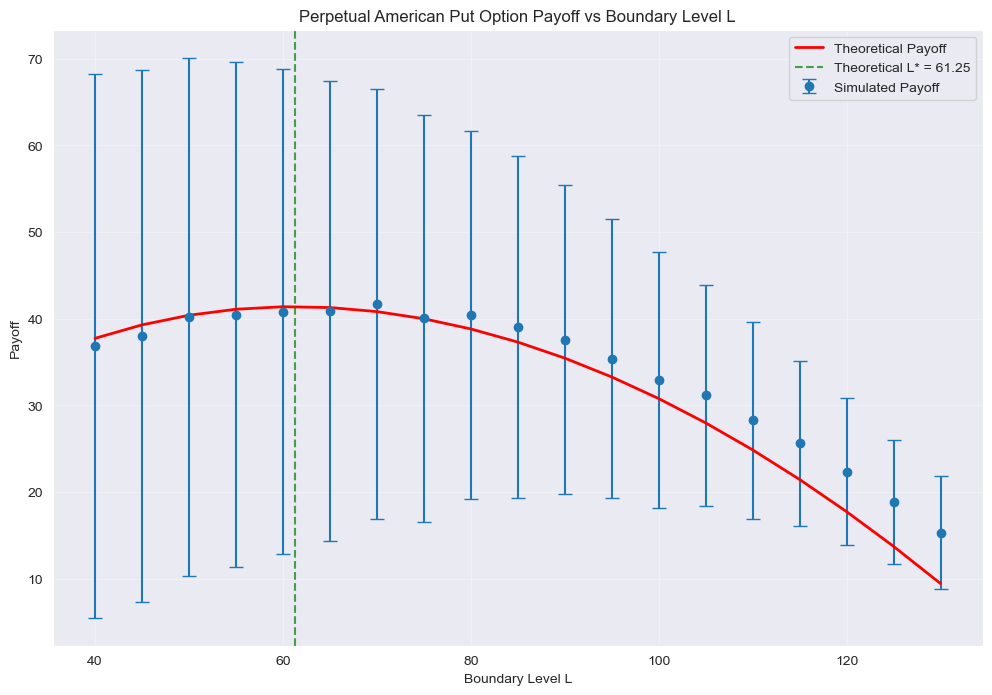


Optimal boundary analysis:
Simulated optimal L: 70.0
Theoretical optimal L: 61.25
Maximum simulated payoff: 41.6952
Theoretical payoff at optimal L: 41.4010


In [26]:
# First, let's calculate the theoretical optimal boundary
alpha = (2 * r) / (2 * r + sigma**2)
theoretical_optimal_L = K * alpha

print(f"Model parameters:")
print(f"S0 = {S0}, K = {K}, sigma = {sigma}, r = {r}")
print(f"Alpha parameter: {alpha:.4f}")
print(f"Theoretical optimal exercise boundary: L* = {theoretical_optimal_L:.2f}")
print()

# Test L values around the theoretical optimum, but also include the range used before
L_values = np.arange(40, 135, 5)  # More focused range around reasonable values
results = []

print("Running simulations...")
for L in L_values:
    avg_payoff, std_payoff, payoffs, exercise_times = return_for_perpetual_american_option_simulation(L)
    results.append((L, avg_payoff, std_payoff))

# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame(results, columns=['L', 'Average Payoff', 'Std Dev'])
print("\nResults Summary:")
print(results_df)

# Plot the results
plt.figure(figsize=(12, 8))
plt.errorbar(results_df['L'], results_df['Average Payoff'], yerr=results_df['Std Dev'], 
             fmt='o', label='Simulated Payoff', capsize=5, markersize=6)

# Theoretical value calculation - this is the value when starting at S0=140
theoretical_values = []
for L in L_values:
    if S0 <= L:
        # If current price is below boundary, exercise immediately
        theoretical_value = K - S0
    else:
        # If current price is above boundary, use the formula
        theoretical_value = (K - L) * (S0 / L) ** (-2 * r / sigma**2)
    theoretical_values.append(theoretical_value)

plt.plot(L_values, theoretical_values, label='Theoretical Payoff', color='red', linewidth=2)

# Mark the theoretical optimal boundary
plt.axvline(x=theoretical_optimal_L, color='green', linestyle='--', 
            label=f'Theoretical L* = {theoretical_optimal_L:.2f}', alpha=0.7)

plt.xlabel('Boundary Level L')
plt.ylabel('Payoff')
plt.title('Perpetual American Put Option Payoff vs Boundary Level L')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find the optimal L from simulation
optimal_idx = np.argmax(results_df['Average Payoff'])
optimal_L_sim = results_df.iloc[optimal_idx]['L']
max_payoff_sim = results_df.iloc[optimal_idx]['Average Payoff']

print(f"\nOptimal boundary analysis:")
print(f"Simulated optimal L: {optimal_L_sim:.1f}")
print(f"Theoretical optimal L: {theoretical_optimal_L:.2f}")
print(f"Maximum simulated payoff: {max_payoff_sim:.4f}")
print(f"Theoretical payoff at optimal L: {(K - theoretical_optimal_L) * (S0 / theoretical_optimal_L) ** (-2 * r / sigma**2):.4f}")

# Old code

In [6]:
# Calculate theoretical optimal exercise boundary
alpha = (2 * r) / (2 * r + sigma**2)
theoretical_optimal_L = K * alpha

print(f"Alpha parameter: {alpha:.4f}")
print(f"Theoretical optimal exercise boundary: L* = {theoretical_optimal_L:.2f}")

Alpha parameter: 0.4375
Theoretical optimal exercise boundary: L* = 61.25


Testing 15 different exercise boundaries with 50000 simulations each...
L = 42.88: Average payoff = $20.0198 ± $0.1623
L = 45.50: Average payoff = $21.3921 ± $0.1626
L = 48.12: Average payoff = $22.7641 ± $0.1623
L = 50.75: Average payoff = $23.6583 ± $0.1602
L = 53.38: Average payoff = $25.0275 ± $0.1585
L = 56.00: Average payoff = $26.1864 ± $0.1561
L = 58.63: Average payoff = $26.8823 ± $0.1525
L = 61.25: Average payoff = $27.3939 ± $0.1483
L = 63.88: Average payoff = $27.7022 ± $0.1436
L = 66.50: Average payoff = $28.3603 ± $0.1391
L = 69.12: Average payoff = $28.7456 ± $0.1338
L = 71.75: Average payoff = $28.7257 ± $0.1284
L = 74.38: Average payoff = $29.0276 ± $0.1229
L = 77.00: Average payoff = $28.9412 ± $0.1171
L = 79.63: Average payoff = $28.4608 ± $0.1114

Results:
Optimal L (simulated): 74.38
Maximum average payoff: $29.0276
Theoretical optimal L: 61.25
Difference: 13.13


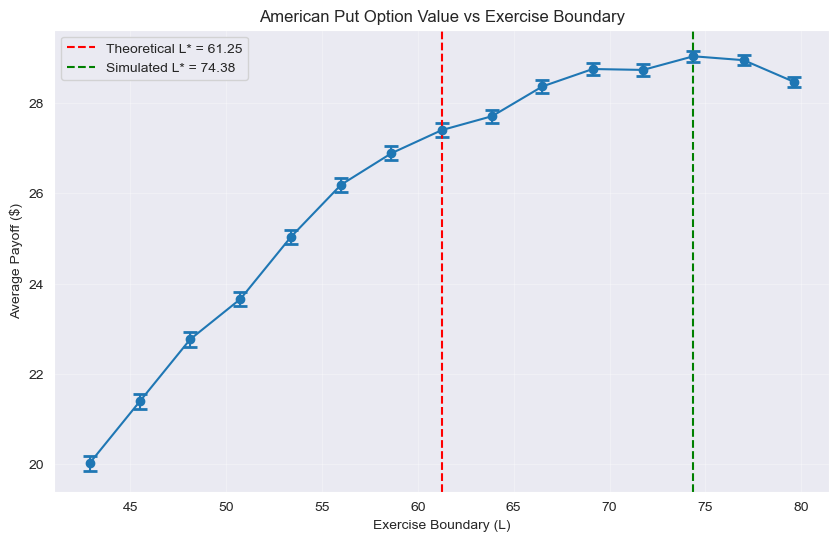

In [10]:
# Find optimal exercise boundary through Monte Carlo simulation
alpha = (2 * r) / (2 * r + sigma**2)
theoretical_L = K * alpha

# Test range of L values around theoretical optimum
L_values = np.linspace(theoretical_L * 0.7, theoretical_L * 1.3, 15)
payoff_means = []
payoff_stds = []

sim = 50000
print(f"Testing {len(L_values)} different exercise boundaries with {sim} simulations each...")

for idx, L in enumerate(L_values):
    paths = GBM_paths(S0, sigma, t, r, mu, sim, n_steps)
    
    payoffs = []
    for i in range(sim):
        path = paths[i]
        exercised = False
        
        for j in range(len(path)):
            if path[j] <= L:
                remaining_time = t * (1 - j / n_steps)
                payoff = put_option_payoff(path[j], K, r, remaining_time)
                payoffs.append(payoff)
                exercised = True
                break
        
        if not exercised:
            payoffs.append(0)
    
    avg_payoff = np.mean(payoffs)
    std_payoff = np.std(payoffs)
    payoff_means.append(avg_payoff)
    payoff_stds.append(std_payoff)
    
    print(f"L = {L:.2f}: Average payoff = ${avg_payoff:.4f} ± ${std_payoff/np.sqrt(sim):.4f}")

# Find optimal L
optimal_idx = np.argmax(payoff_means)
optimal_L = L_values[optimal_idx]
max_payoff = payoff_means[optimal_idx]

print(f"\nResults:")
print(f"Optimal L (simulated): {optimal_L:.2f}")
print(f"Maximum average payoff: ${max_payoff:.4f}")
print(f"Theoretical optimal L: {theoretical_L:.2f}")
print(f"Difference: {abs(optimal_L - theoretical_L):.2f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.errorbar(L_values, payoff_means, yerr=np.array(payoff_stds)/np.sqrt(sim), 
             marker='o', capsize=5, capthick=2)
plt.axvline(x=theoretical_L, color='r', linestyle='--', 
            label=f'Theoretical L* = {theoretical_L:.2f}')
plt.axvline(x=optimal_L, color='g', linestyle='--', 
            label=f'Simulated L* = {optimal_L:.2f}')
plt.xlabel('Exercise Boundary (L)')
plt.ylabel('Average Payoff ($)')
plt.title('American Put Option Value vs Exercise Boundary')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Variance Reduction Techniques

Let's implement several techniques to reduce the standard deviation of our simulation results.

In [ ]:
# 1. Increase Number of Simulations
# Current: 2000 simulations. Let's test with more simulations

def test_simulation_count_effect():
    """Test how increasing simulation count affects standard deviation."""
    sim_counts = [1000, 2000, 5000, 10000, 20000]
    L_test = 80  # Use a fixed L value for testing
    
    results = []
    for n_sim in sim_counts:
        # Create new simulator with different simulation count
        sps_test = StockPathSimulator(
            S0=S0, sigma=sigma, t=t, r=r, mu=mu, 
            n_sims=n_sim, n_steps=n_steps
        )
        
        # Generate paths
        paths = sps_test.simulate_paths()
        payoffs = []
        
        for i in range(n_sim):
            path = paths[i]
            exercised = False
            
            if path[0] <= L_test:
                payoff = sps_test.put_option_payoff(path[0], K, 0)
                payoffs.append(payoff)
                exercised = True
            else:
                for j in range(1, len(path)):
                    if path[j] <= L_test:
                        exercise_time = t * (j / n_steps)
                        payoff = sps_test.put_option_payoff(path[j], K, exercise_time)
                        payoffs.append(payoff)
                        exercised = True
                        break
            
            if not exercised:
                payoffs.append(0)
        
        avg_payoff = np.mean(payoffs)
        std_payoff = np.std(payoffs)
        std_error = std_payoff / np.sqrt(n_sim)  # Standard error of the mean
        
        results.append((n_sim, avg_payoff, std_payoff, std_error))
        print(f"N={n_sim:5d}: Avg={avg_payoff:.4f}, Std={std_payoff:.4f}, SE={std_error:.4f}")
    
    return results

print("Testing effect of simulation count on standard deviation:")
sim_results = test_simulation_count_effect()